In [3]:
import json, sys, random, os, warnings
from PIL import Image
import pathlib as pl
from air_bus.airbus_utils import rle_decode, rle_encode, save_img, same_id
from air_bus.decorate import profile
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### from the Airbus Ship Detection Challenge evaluation page

This competition is evaluated on the F2 Score at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
IoU(A,B)=A∩/BA∪B.


The metric sweeps over a range of IoU thresholds, at each point calculating an F2 Score. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value t
, the F2 Score value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects. The following equation is equivalent to F2 Score when β is set to 2:
$$
F\beta(t) = \frac{(1 + \beta^2) \cdot TP(t)}{(1 + \beta^2) \cdot TP(t) + \beta^2 \cdot FN(t) + FP(t)}.
AtruepositiveiscountedwhenasinglepredictedobjectmatchesagroundtruthobjectwithanIoUabovethethreshold.Afalsepositiveindicatesapredictedobjecthadnoassociatedgroundtruthobject.Afalsenegativeindicatesagroundtruthobjecthadnoassociatedpredictedobject.TheaverageF2ScoreofasingleimageisthencalculatedasthemeanoftheaboveF2ScorevaluesateachIoUthreshold:
\frac{1}{|thresholds|} \sumt F_2(t).
$$
Lastly, the score returned by the competition metric is the mean taken over the individual average F2 Scores of each image in the test dataset.

The metric used for this competition is defined as the mean average precision at different intersection over union (IoU) thresholds.

This tells us there are a few different steps to getting the score reported on the leaderboard. For each image...

    For each ship "prediction", calculate the Intersection of Union metric with each "ground truth" mask in the image.
    Calculate whether this mask fits at a range of IoU thresholds.
    At each threshold, calculate the precision across all your submitted masks.
    Average the precision across thresholds.

Across the dataset...

    Calculate the mean of the average precision for each image.


root_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data"
train_files_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/train/images"
test_files_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Images/test/images"

train_masks_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Masks/train/masks"
test_masks_dir = "/media/thistle/Passport/Kaggle_Data/airbus/updated_data/Masks/test/masks"


train_files = os.listdir(train_files_dir)
test_files = os.listdir(test_files_dir)
len(train_files), len(test_files)

In [145]:
testing_files = [(test_files[each], train_files[each]) for each in np.random.randint(1,4256, 5)]

In [147]:
testing_files

[('bc225a509.jpg', '577988697.jpg'),
 ('0546baefb.jpg', '47fa16218.jpg'),
 ('5b38976bf.jpg', 'd0e1f65a3.jpg'),
 ('8ff2e334e.jpg', 'c8327dd2e.jpg'),
 ('2d71ff4fc.jpg', 'eb1886768.jpg')]

In [57]:
def load_image(the_dir, str_path):
    # returns a np.array()
    path = os.path.join(the_dir, str_path)
    r = tf.io.read_file(path)
    i = tf.io.decode_jpeg(r)
    return i.numpy()

# shifting masks
def shift_right(arr, num_shift):
    # remove right num cols
    arr_temp = arr[:, :-num_shift]
    shape = arr_temp.shape
    to_add = np.zeros((shape[0],num_shift))
    new_arr = np.concatenate((to_add, arr_temp), axis=1)
    return np.squeeze(new_arr.astype("uint8"))

# shifting masks
def shift_left(arr, num_shift):
    # remove left num cols
    arr_temp = arr[:, num_shift:]
    shape = arr_temp.shape
    to_add = np.zeros((shape[0],num_shift))
    new_arr = np.concatenate((arr_temp, to_add), axis=1)
    return np.squeeze(new_arr.astype("uint8"))

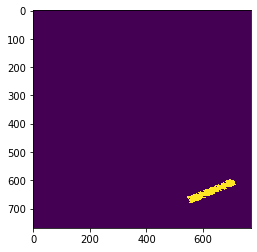

In [148]:
file1 = testing_files[3][0]
img = load_image(test_masks_dir, file1)
plt.imshow(np.squeeze(img))

In [149]:
np.sum(img) # this is intersection op

4165

In [158]:
shifted_img = shift_right(np.squeeze(img),3)

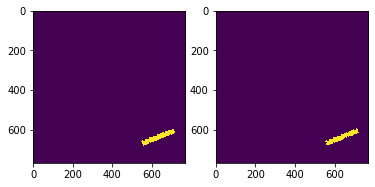

In [159]:
f, a = plt.subplots(1,2)
a[0].imshow(np.squeeze(img))
a[1].imshow(shifted_img)

In [160]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
iou = lambda num_i, num_u: num_i/num_u


Intersection Over Union (for a single Prediction-GroundTruth comparison)

    The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
    IoU(A,B)=A∩B/A∪B

Let's take one of the ship masks from our GroundTruth and Predicted volumes. Their intersections and unions look like this:


In [166]:
file1 = testing_files[0][0]

In [169]:
gt = load_img(file1) # the ground truth
pr = shift_right(gt, 1) # may shifted image
intersection= np.logical_and(A,B)
union = np.logical_or(A,B)

num_inter_pix = np.sum(intersection)
num_union_pix = np.sum()
iou = np.sum(intersection)/np.sum(union)


NameError: name 'get_image' is not defined

In [ ]:
f, a = plt.subplots()

In [161]:
def get_iou_vector(A, B):
    intersection= np.logical_and(A,B)
    union = np.logical_or(A,B)
    iou = np.sum(intersection)/np.sum(union)
    does_pass = []
    for thresh in thresholds:
        does_pass.append(iou>thresh)
    return does_pass

In [162]:
z = get_iou_vector(np.squeeze(img), shifted_img) 

In [163]:
z

[True, True, True, True, True, True, True, False, False, False]

In [126]:
s = pd.Series(name = 'Ground_vs_Pred')

In [127]:
s

Series([], Name: Fred, dtype: float64)

In [ ]:


for i in 

In [95]:
z = np.squeeze(img) * shifted_img
np.sum(z)

13234

In [97]:
z = img * img
np.sum(z)

17346

In [85]:
np.sum(shifted_img)

17342

In [77]:
img.max(), shifted_img.min()

(1, 0)

In [78]:
i = img[:,-1:]

In [82]:
np.sum(np.squeeze(i))

4

In [32]:
zz = shift_right(z,1)
zz

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [26]:
zz

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])